Funnel Sheet questions

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

from sklearn.metrics import mean_squared_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# for lstm
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
data = pd .read_excel("/content/Intern Hiring Assignment Data.xlsx",
                      sheet_name='Funnel')
data.head()

,Year,Month,Customer Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,1354648.0
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.0
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.0
3,2020,12,Clients,India,Lv4_Visitors,Actuals,NaN
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.0


In [4]:
data.describe().applymap('{:,.4f}'.format)

,Year,Month,Value
count,"1,572.0000","1,572.0000","1,547.0000"
mean,"2,021.1298",6.5000,"268,584.4590"
std,0.8328,3.4532,"644,440.5529"
min,"2,020.0000",1.0000,137.0000
25%,"2,020.0000",3.7500,"9,292.0000"
50%,"2,021.0000",6.5000,"32,564.0000"
75%,"2,022.0000",9.2500,"172,619.5000"
max,"2,022.0000",12.0000,"4,703,447.0000"


In [5]:
data.dtypes

Year                  int64
Month                 int64
Customer Segment     object
Region               object
KPI                  object
Value Type           object
Value               float64
dtype: object

In [6]:
data.duplicated().sum()

0

In [7]:
data.isna().sum()

Year                 0
Month                0
Customer Segment     0
Region               0
KPI                  0
Value Type           0
Value               25
dtype: int64

In [8]:
# Since data has outliers Median is Appropriate method.
data['Value'].fillna(data['Value'].median(), inplace=True)
data.isna().sum()

Year                0
Month               0
Customer Segment    0
Region              0
KPI                 0
Value Type          0
Value               0
dtype: int64

In [9]:
# unique values of columns
for col in data.columns[:-1]:

        unique_values = data[col].unique()
        print(f"Column '{col}' has {len(unique_values)} unique value(s): {unique_values}")



Column 'Year' has 3 unique value(s): [2020 2021 2022]
Column 'Month' has 12 unique value(s): [12 11 10  9  8  7  6  5  4  3  2  1]
Column 'Customer Segment' has 2 unique value(s): ['Clients' 'Customers']
Column 'Region' has 7 unique value(s): ['India' 'Uddepy' 'Dehradun' 'Ujjain' 'Indore' 'Faridabad' 'Aurangabad']
Column 'KPI' has 5 unique value(s): ['Lv1_Visitors' 'Lv2_Visitors' 'Lv3_Visitors' 'Lv4_Visitors'
 'Lv5_Visitors']
Column 'Value Type' has 1 unique value(s): ['Actuals']


In [10]:
data.drop('Value Type',axis=1,inplace=True)

In [11]:
label_encoding = {"Customer Segment":     {"Clients": 1, "Customers": 2},
                "Region": {"India": 1, "Uddepy": 2, "Dehradun": 3, "Ujjain": 4,
                                  "Indore": 5, "Faridabad": 6, "Aurangabad":7 },
                "KPI": {'Lv1_Visitors':1, 'Lv2_Visitors':2, 'Lv3_Visitors':3, 'Lv4_Visitors':4, 'Lv5_Visitors':5}}
data= data.replace(label_encoding)

In [12]:

data

,Year,Month,Customer Segment,Region,KPI,Value
0,2020,12,1,1,1,1354648.0
1,2020,12,1,1,2,2689569.0
2,2020,12,1,1,3,1300571.0
3,2020,12,1,1,4,32564.0
4,2020,12,1,1,3,706677.0
...,...,...,...,...,...,...
1567,2022,1,2,3,5,1693.0
1568,2022,1,2,7,4,1428.0
1569,2022,1,2,4,5,1311.0
1570,2022,1,2,6,5,1071.0


In [13]:
# Add a "date" datetime column
data['Date']=pd.to_datetime(dict(year=data['Year'], month=data['Month'], day=1))

In [14]:
def plot_kpi_category_distribution(data, start_year, start_month, end_year, end_month):
    # Filter data based on date range
    filtered_data = data[(data['Year'] >= start_year) &
                         (data['Month'] >= start_month) &
                         (data['Year'] <= end_year) &
                         (data['Month'] <= end_month)]

    filtered_data['Date'] = filtered_data['Date'].dt.date

    # Group data by Date and KPI category and count occurrences
    kpi_category_counts = filtered_data.groupby(['Date', 'KPI']).size().unstack(fill_value=0)


    # Create a bar chart
    kpi_category_counts.plot(kind='bar', stacked=False, figsize=(20, 10))

    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title('KPI Category Distribution')
    plt.xticks(rotation=45)
    plt.show()

    # Create a stacked line chart

    kpi_category_counts.plot(kind='line', stacked=True, figsize=(10, 7))

    plt.xlabel('Date')

    plt.ylabel('Count')
    plt.title('KPI Category Distribution')
    plt.xticks(rotation=45)
    plt.show()


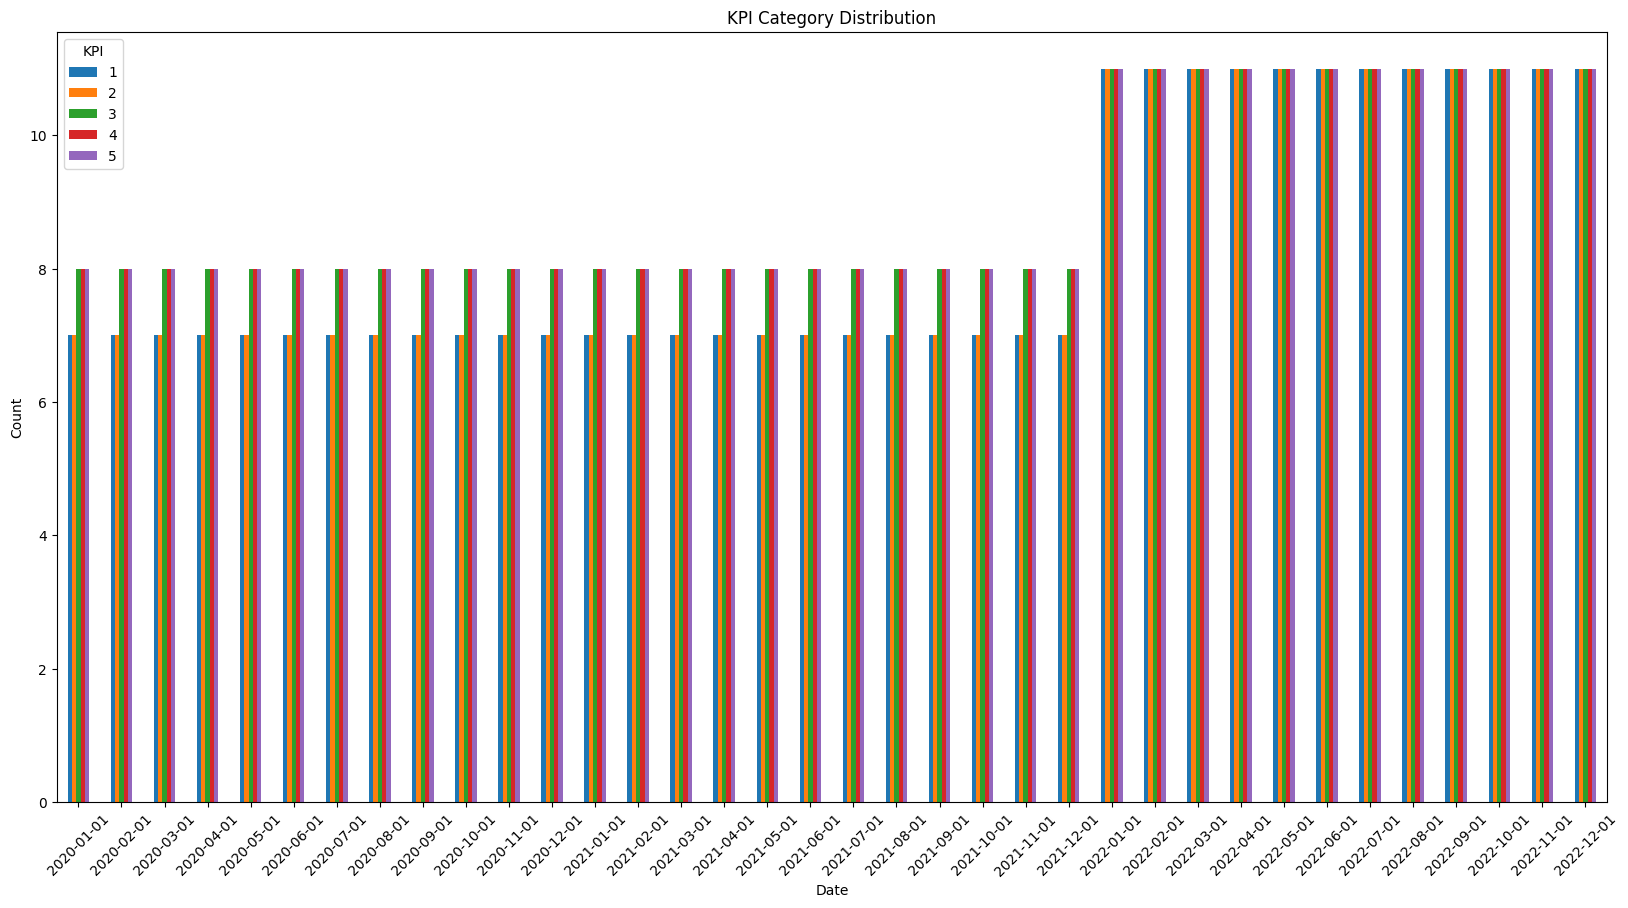

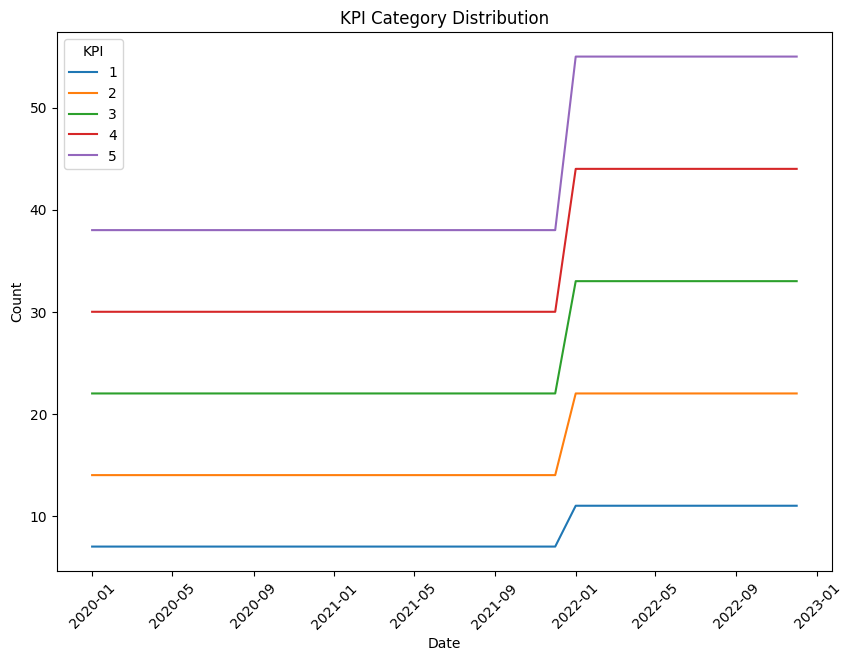

In [15]:
plot_kpi_category_distribution(data, 2020, 1, 2022, 12)

In [16]:
# Set "date" to be the index
data.set_index('Date',inplace=True)
data.head()

,Year,Month,Customer Segment,Region,KPI,Value
Date,,,,,,
2020-12-01,2020,12,1,1,1,1354648.0
2020-12-01,2020,12,1,1,2,2689569.0
2020-12-01,2020,12,1,1,3,1300571.0
2020-12-01,2020,12,1,1,4,32564.0
2020-12-01,2020,12,1,1,3,706677.0


In [17]:
aggregated_data = data.groupby('Date').mean()
#auto_arima(aggregated_data['Value'],seasonal=True,m=12).summary()
aggregated_data.head(15)

,Year,Month,Customer Segment,Region,KPI,Value
Date,,,,,,
2020-01-01,2020.0,1.0,1.789474,3.236842,3.078947,276354.052632
2020-02-01,2020.0,2.0,1.789474,3.236842,3.078947,276170.947368
2020-03-01,2020.0,3.0,1.789474,3.236842,3.078947,319189.736842
2020-04-01,2020.0,4.0,1.789474,3.236842,3.078947,397369.131579
2020-05-01,2020.0,5.0,1.789474,3.236842,3.078947,448759.868421
2020-06-01,2020.0,6.0,1.789474,3.236842,3.078947,369991.421053
2020-07-01,2020.0,7.0,1.789474,3.236842,3.078947,321030.473684
2020-08-01,2020.0,8.0,1.789474,3.236842,3.078947,246278.394737
2020-09-01,2020.0,9.0,1.789474,3.236842,3.078947,290040.552632


In [18]:
# Forecasting using sarima
def sarima_forecast(data, start, end):

    # Assuming 'Value' is the column you want to forecast

    model = SARIMAX(data['Value'],order=(0,1,0))
    results = model.fit()
    results.summary()

    # Predication
    predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0) Predictions')
    predictions = predictions.to_list()
    # Combine actual and forecasted values into a DataFrame
    forecast_df = pd.DataFrame({'Actual': data['Value'], 'Forecasted_Sarima': predictions})

    # Save to CSV
    forecast_df.to_csv('forecast.csv', index=False)

In [19]:
sarima_forecast(aggregated_data,1,36)

In [20]:
def lstm_forecast(data):

  # scale features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  #split the dataset
  X=scaled_data[:,:-1]
  Y=scaled_data[:,-1]
  X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state = 3)
  X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
  X_valid = X_test.reshape((X_test.shape[0],1 , X_test.shape[1]))

  serie_size =  X_train.shape[1] # 12
  n_features =  X_train.shape[2] # 1

  epochs = 50
  batch = 10
  lr = 0.01
  # model building
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(serie_size, n_features)))
  model.add(Dropout(0.3))
  model.add(LSTM(50, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  #fitting of model
  lstm_history = model.fit(X_train, y_train,
                              validation_data=(X_valid, y_test),
                              batch_size=batch,
                              epochs=epochs,
                              verbose=2,
                         callbacks=[early_stopping])

  #Predict and make dataset
  X = X.reshape((X.shape[0],1, X.shape[1]))
  yhat1 = model.predict(X)
  X = X.reshape(X.shape[0], 5)
  inv_yhat1 = np.concatenate((yhat1, X[:, :]), axis=1)
  inv_yhat1 = scaler.inverse_transform(inv_yhat1)
  inv_yhat1_df = pd.DataFrame(inv_yhat1)
  forecast = pd.read_csv("/content/forecast.csv")
  forecast = pd.concat([forecast, inv_yhat1_df.iloc[:,5]], axis=1)
  forecast.columns = ['Actual', 'Forecasted_Sarima','Forecasted_lstm']
  forecast.to_csv('forecast.csv', index=False)

In [21]:
lstm_forecast(aggregated_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3/3 - 1

In [22]:
def moving_average_forecast(data, window_size):
    # Calculate the moving average
    moving_avg=aggregated_data.rolling(window=3).mean()['Value']

    forecast_mo_avg = moving_avg.shift(-1)
    forecast_mo_avg = pd.DataFrame(forecast_mo_avg).reset_index()
    #print(forecast_mo_avg.head())
    forecast = pd.read_csv("/content/forecast.csv")
    forecast = pd.concat([forecast, forecast_mo_avg['Value']], axis=1,ignore_index=True)
    forecast.columns = ['Actual', 'Forecasted_Sarima','Forecasted_lstm','Forecasted_moving_avg']
    forecast.to_csv('forecast.csv', index=False)

In [23]:
moving_average_forecast(aggregated_data,3)

In [24]:
forecast = pd.read_csv("/content/forecast.csv")
forecast.head(15)

,Actual,Forecasted_Sarima,Forecasted_lstm,Forecasted_moving_avg
0,276354.052632,276354.052632,448759.868421,NaN
1,276170.947368,276170.947368,448759.868421,290571.578947
2,319189.736842,319189.736842,448759.868421,330909.938596
3,397369.131579,397369.131579,448759.868421,388439.578947
4,448759.868421,448759.868421,448759.868421,405373.473684
5,369991.421053,369991.421053,448759.868421,379927.254386
6,321030.473684,321030.473684,448759.868421,312433.429825
7,246278.394737,246278.394737,448759.868421,285783.140351
8,290040.552632,290040.552632,448759.868421,302617.859649
9,371534.631579,371534.631579,448759.868421,328877.543860


In [30]:
def calculate_mape_mse(actual, forecasted):

    mape = (abs(actual - forecasted) / actual).mean() * 100
    mse = mean_squared_error(actual,forecasted)
    return mape,mse

sarima_mape,sarima_mse = calculate_mape_mse(forecast['Actual'],forecast['Forecasted_Sarima'])
lstm_mape,lstm_mse = calculate_mape_mse(forecast['Actual'],forecast['Forecasted_lstm'])
forecast1=forecast.dropna()
mov_avg_mape,mov_avg_mse = calculate_mape_mse(forecast1['Actual'],forecast1['Forecasted_moving_avg'])

print(f"MAPE of Sarima is {sarima_mape} and MSE of Sarima is {sarima_mse}")
print(f"MAPE of lstm is {lstm_mape} and MSE of lstm is {lstm_mse}")
print(f"MAPE of Moving_Avg is {mov_avg_mape} and MSE of Moving_Avg is {mov_avg_mse}")

MAPE of Sarima is 0.0 and MSE of Sarima is 0.0
MAPE of lstm is 50.19923839944268 and MSE of lstm is 20632558901.944477
MAPE of Moving_Avg is 6.258420821638469 and MSE of Moving_Avg is 500246838.7616545


Best Model for our dataset is Moving Average but The MSE(mean Squared error) is huge since it squares the (actual - predicted) value and our "Value" Column contains 10^6 units value, But the Mape Small which is good sign. Hence for using Moving average we must use MAPE for Evaluation. In case of Lstm and Sarima Since the aggregated dataset is a very small lstm does not perform good(deep learning models requires big data) while in csae of Sarima model is overfitting.

AB_Test Sheet questions

In [37]:
abtest = pd.read_excel("/content/Intern Hiring Assignment Data.xlsx",sheet_name="ABTest")
abtest.head()


,Months (Date),Date,Variants,DeviceType,Sum of Clicks,Sum of Visitors
0,Mar,2023-03-29,Control,Desktop,31312,298032
1,Mar,2023-03-29,Control,Mobile,18399,192144
2,Mar,2023-03-29,Control,Others,34,375
3,Mar,2023-03-29,Control,Tablet,660,7646
4,Mar,2023-03-29,Treatment,Desktop,10067,32737


In [44]:
abtest['Sum of Clicks/Sum of Visitors'] = abtest["Sum of Clicks"]/abtest["Sum of Visitors"]
abtest.head()

,Months (Date),Date,Variants,DeviceType,Sum of Clicks,Sum of Visitors,Sum of Clicks/Sum of Visitors
0,Mar,2023-03-29,Control,Desktop,31312,298032,0.105063
1,Mar,2023-03-29,Control,Mobile,18399,192144,0.095756
2,Mar,2023-03-29,Control,Others,34,375,0.090667
3,Mar,2023-03-29,Control,Tablet,660,7646,0.086320
4,Mar,2023-03-29,Treatment,Desktop,10067,32737,0.307511


In [31]:
import statsmodels.api as sm
from statsmodels.stats.power import NormalIndPower

# Given values
MDE = 0.03
alpha = 0.05
power = 0.80

p = 0.5

# Calculate required sample size using Normal distribution
effect_size = sm.stats.proportion_effectsize(p, p + MDE)
sample_size = NormalIndPower().solve_power(effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')

print(f"Required Sample Size: {sample_size:.0f}")

Required Sample Size: 4355


In [47]:
import scipy.stats as stats


control_group_data = abtest[abtest['Variants'] == "Control"]["Sum of Clicks/Sum of Visitors"]
treatment_group_data = abtest[abtest['Variants'] == "Treatment"]["Sum of Clicks/Sum of Visitors"]

# Perform a t-test (assuming independent samples, can be different depending on your data)
t_stat, p_value = stats.ttest_ind(control_group_data, treatment_group_data)

alpha = 0.05

# Check if the p-value is less than alpha
if p_value < alpha:
    print("The test reached statistical significance at 95% confidence level.")
else:
    print("The test did not reach statistical significance at 95% confidence level.")

The test reached statistical significance at 95% confidence level.


In [51]:
import scipy.stats as stats

desktop_control_data = abtest[(abtest['Variants'] == "Control") & (abtest['DeviceType'] == "Desktop")]["Sum of Clicks/Sum of Visitors"]
desktop_treatment_data = abtest[(abtest['Variants'] == "Treatment") & (abtest['DeviceType'] == "Desktop")]["Sum of Clicks/Sum of Visitors"]
mobile_control_data = abtest[(abtest['Variants'] == "Control") & (abtest['DeviceType'] == "Mobile")]["Sum of Clicks/Sum of Visitors"]
mobile_treatment_data = abtest[(abtest['Variants'] == "Treatment") & (abtest['DeviceType'] == "Mobile")]["Sum of Clicks/Sum of Visitors"]

# Perform t-tests for Desktop and Mobile data separately
desktop_t_stat, desktop_p_value = stats.ttest_ind(desktop_control_data, desktop_treatment_data)
mobile_t_stat, mobile_p_value = stats.ttest_ind(mobile_control_data, mobile_treatment_data)

alpha = 0.05

# Check if the p-value for Desktop data is less than alpha
if desktop_p_value < alpha:
    print("The test for Desktop data reached statistical significance at 95% confidence level.")
else:
    print("The test for Desktop data did not reach statistical significance at 95% confidence level.")

# Check if the p-value for Mobile data is less than alpha
if mobile_p_value < alpha:
    print("The test for Mobile data reached statistical significance at 95% confidence level.")
else:
    print("The test for Mobile data did not reach statistical significance at 95% confidence level.")

The test for Desktop data reached statistical significance at 95% confidence level.
The test for Mobile data reached statistical significance at 95% confidence level.


In [52]:
import statsmodels.api as sm
from statsmodels.stats.power import NormalIndPower

def calculate_sample_size(MDE, alpha, power):

    # Validate input ranges
    if not (0 <= MDE <= 1) or not (0 < alpha < 1) or not (0 < power < 1):
        raise ValueError("MDE, alpha, and power must be within valid ranges.")

    p = 0.5

    # Calculate effect size
    effect_size = sm.stats.proportion_effectsize(p, p + MDE)

    # Calculate required sample size using Normal distribution
    sample_size = NormalIndPower().solve_power(
        effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided'
    )

    return int(sample_size)

In [53]:
calculate_sample_size(0.03,0.05,0.8)

4355

In [54]:
import scipy.stats as stats

def perform_t_test(control_data, treatment_data, alpha=0.05):

    t_stat, p_value = stats.ttest_ind(control_data, treatment_data)
    # Check if the p-value is less than alpha
    if p_value < alpha:
        print("The test reached statistical significance at 95% confidence level.")
    else:
        print("The test did not reach statistical significance at 95% confidence level.")


In [55]:
control_group_data = abtest[abtest['Variants'] == "Control"]["Sum of Clicks/Sum of Visitors"]
treatment_group_data = abtest[abtest['Variants'] == "Treatment"]["Sum of Clicks/Sum of Visitors"]
perform_t_test(control_group_data,treatment_group_data)

The test reached statistical significance at 95% confidence level.


In [57]:
import scipy.stats as stats

def perform_t_tests1(desktop_control_data, desktop_treatment_data, mobile_control_data, mobile_treatment_data, alpha=0.05):

    desktop_t_stat, desktop_p_value = stats.ttest_ind(desktop_control_data, desktop_treatment_data)
    mobile_t_stat, mobile_p_value = stats.ttest_ind(mobile_control_data, mobile_treatment_data)

    # Check if the p-value for Desktop data is less than alpha
    if desktop_p_value < alpha:
        print("The test for Desktop data reached statistical significance at 95% confidence level.")
    else:
        print("The test for Desktop data did not reach statistical significance at 95% confidence level.")

    # Check if the p-value for Mobile data is less than alpha
    if mobile_p_value < alpha:
        print("The test for Mobile data reached statistical significance at 95% confidence level.")
    else:
        print("The test for Mobile data did not reach statistical significance at 95% confidence level.")

In [58]:
desktop_control_data = abtest[(abtest['Variants'] == "Control") & (abtest['DeviceType'] == "Desktop")]["Sum of Clicks/Sum of Visitors"]
desktop_treatment_data = abtest[(abtest['Variants'] == "Treatment") & (abtest['DeviceType'] == "Desktop")]["Sum of Clicks/Sum of Visitors"]
mobile_control_data = abtest[(abtest['Variants'] == "Control") & (abtest['DeviceType'] == "Mobile")]["Sum of Clicks/Sum of Visitors"]
mobile_treatment_data = abtest[(abtest['Variants'] == "Treatment") & (abtest['DeviceType'] == "Mobile")]["Sum of Clicks/Sum of Visitors"]
perform_t_tests1(desktop_control_data,desktop_treatment_data,mobile_control_data,mobile_treatment_data)

The test for Desktop data reached statistical significance at 95% confidence level.
The test for Mobile data reached statistical significance at 95% confidence level.


Writing skills


During this Full-Time internship, I plan to maximize my learning and contribution by adopting a proactive and strategic approach. I'll begin by immersing myself in the company culture, understanding its values, and aligning my work with its goals. By actively seeking mentorship and networking opportunities, I aim to absorb insights from experienced professionals, gaining practical knowledge beyond textbooks.

I'll take ownership of my tasks, ensuring they're executed meticulously and contribute meaningfully to projects. Regularly seeking feedback will be pivotal for continuous improvement. I also aspire to engage in cross-functional collaborations, broadening my understanding of various departments and their interdependencies.

Moreover, I'll leverage this internship to hone both technical and soft skills, applying them to real-world challenges. By immersing myself in diverse projects, I aim to gain a comprehensive understanding of industry practices and trends.

This opportunity is invaluable for my career growth. It provides a platform to apply my knowledge in a professional setting, bridging the gap between academia and industry. The exposure to real-time projects, alongside experienced professionals, will enhance my problem-solving abilities and decision-making skills. Additionally, it offers a chance to build a professional network, opening doors to potential future collaborations. Ultimately, this internship is a crucial stepping stone towards achieving my long-term career goals and establishing myself as a capable and adaptable professional in the industry.